In [1]:
__author__ = 'Robert Nikutta <nikutta@noao.edu>, NOAO Data Lab Team <datalab@noao.edu>'
__version__ = '20170522' # yyymmdd

# Time-series analysis of a RR Lyrae star
We will study the variability of an astrophysical object as a function of time. In the Hydra II dwarf galaxy, one object is a RR Lyrae star. We'll get the lightcurve for it from the SMASH survey's `source` table.

*Robert Nikutta & NOAO Data Lab Team*

## Imports and setup

In [2]:
# std lib
import sys
from itertools import cycle

# 3rd party
import numpy as np
from astropy import stats
import pylab as plt
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%matplotlib inline

# Data Lab
from dl import helpers

# plotting setup
plt.rcParams['font.size'] =  14
plt.rcParams['figure.figsize'] = (8, 6)

## Make a query helper

In [3]:
Q = helpers.Querist('anonymous') # log in with your username, here 'anonymous'

Authentication successful.


## Retrieve multi-band lightcurves of the star using Data Lab
We can retrieve all calibrated magnitudes of a specific object, for all bands, and all epochs, from the `source` table.

In [4]:
%%time

# the unique this happens to be a RR Lyrae star in Hydra II
objID = '169.429960'
# Select columns: mod. Julian date, calib. mag, uncertainties, filter band
# Note: this database table encodes 'no measurement' values as 99.99
# Order the measurements my ascending date
query = "SELECT mjd,cmag,cerr,filter FROM smash_dr1.source WHERE id='%s' AND cmag<99 ORDER BY mjd ASC" % objID
df = Q(query,outfmt='pandas')
print df.head()

Returning Pandas dataframe
            mjd     cmag      cerr filter
0  56371.327538  21.4331  0.020651      g
1  56371.328563  21.2316  0.022473      r
2  56371.329582  21.1491  0.026192      i
3  56371.330610  21.2379  0.045429      z
4  56371.331633  21.3467  0.015112      g
CPU times: user 12 ms, sys: 6 ms, total: 18 ms
Wall time: 60.5 ms


## Plot light-curves per-band
Plot the light-curves of this source separately for every band. We also zoom in on a range of dates with interesting measurements.

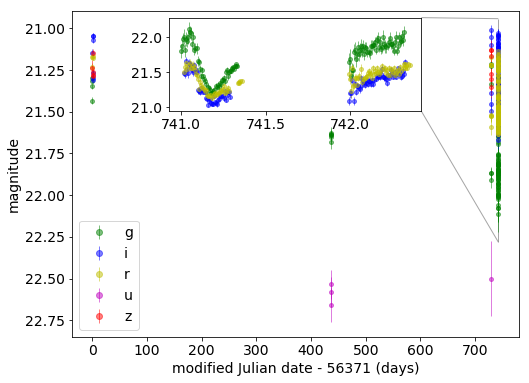

In [5]:
filters = np.unique(df['filter'])
pcolors = cycle(('g','b','y','m','r')) # plotting colors, as a circular list
jd0 = int(df['mjd'].min()) # modified Julian date offset
start = 16 # in the inset we'll zoom in on some data

fig, ax = plt.subplots() #figsize=[8, 6]) # main panel
axins = inset_axes(ax, 3.5, 1.3, loc=9) # inset axes object

for j,filt in enumerate(filters):
    sel = (df['filter'] == filt) # select one filter
    t = df['mjd'][sel].values
    y = df['cmag'][sel].values
    dy = df['cerr'][sel].values
    c = pcolors.next()
    ax.errorbar(t-jd0,y,yerr=dy,marker='.',ms=8,ls='none',color=c,lw=1,alpha=0.5,label=filt)
    axins.errorbar(t[start:]-jd0,y[start:],yerr=dy[start:],marker='.',ms=8,ls='none',lw=1,color=c,alpha=0.5,label=filt)

# Main panel chores
ax.set_xlabel('modified Julian date - %g (days)' % jd0)
ax.set_ylabel('magnitude')
ax.invert_yaxis()
ax.legend(loc='lower left',frameon=True,ncol=1,markerscale=1.5)

# draw bbox around inset; connect with parent axes
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5",lw=1,alpha=0.7);

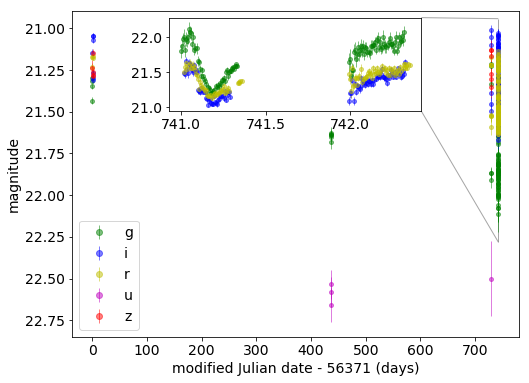

In [6]:
fig

## Find periodicity
One of many methods for finding the period of a variable is the Lomb-Scargle periodogram. It works in the Fourier domain. We'll apply it here to all g band measurements of our RR Lyrae star.

In [7]:
# Select all measurements with the g aband filter
sel = (df['filter'] == 'g')
t = df['mjd'][sel].values
y = df['cmag'][sel].values
dy = df['cerr'][sel].values

# Use astropy's LombScargle class
ls = stats.LombScargle(t, y)

# Compute the periodogram
#   We guide the algorithm a bit:
#     min freq = 1/longest expected period (in days)
#     max freq = 1/shortest expected perdiod (in days)
#   RR Lyrae usually have a period of a fraction of one day
frequency, power = ls.autopower(minimum_frequency=1./1.,maximum_frequency=1./0.1)

period = 1./frequency # period is the inverse of frequency
best_period = 1./frequency[np.argmax(power)]  # period with most power

## Plot periodogram

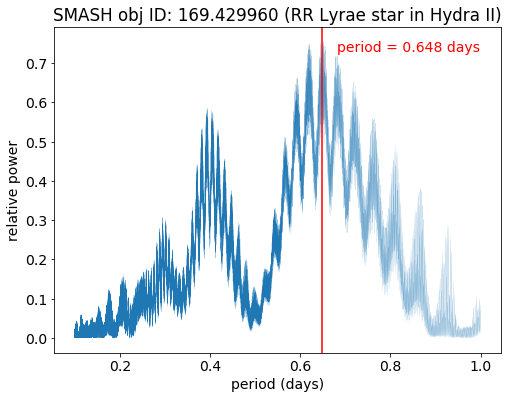

In [8]:
fig = plt.figure()
plt.plot(period,power,lw=0.1)
plt.xlabel('period (days)')
plt.ylabel('relative power')
plt.title('SMASH obj ID: 169.429960 (RR Lyrae star in Hydra II)')
plt.axvline(best_period,color='r');
plt.text(1.05*best_period,0.73,'period = %.3f days'%best_period,color='r')

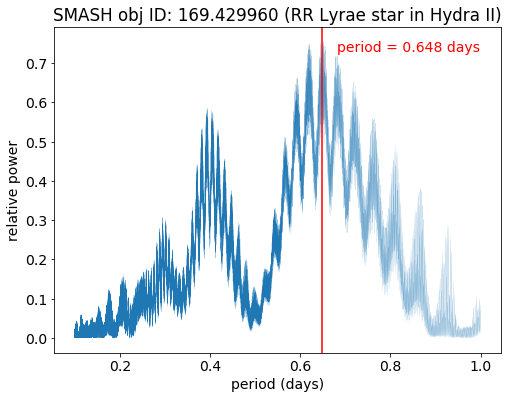

In [9]:
fig

[Vivas et al. 2016](http://adsabs.harvard.edu/abs/2016AJ....151..118V) found with a (complementary!) phase dispersion minimization technique a period of 0.645 days. **We're in excellent agreement :-)**

## Phase the entire lightcurve and plot it

In [10]:
# light curve over period, take the remainder (i.e. the "phase" of one period)
phase = (t / best_period) % 1

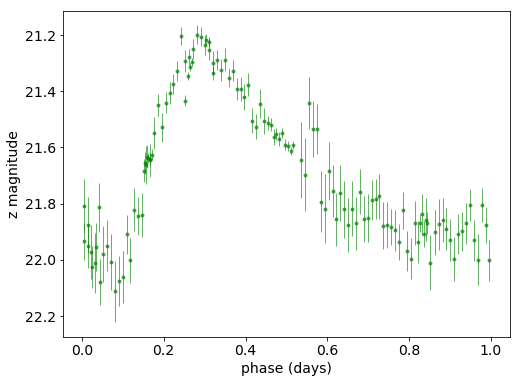

In [11]:
# plot the phased light curve
fig, ax = plt.subplots()
ax.errorbar(phase,y,yerr=dy,marker='.',ls='none',lw=1,color='g',alpha=0.6)
ax.invert_yaxis()
ax.set_xlabel('phase (days)')
ax.set_ylabel('%s magnitude' % filt);

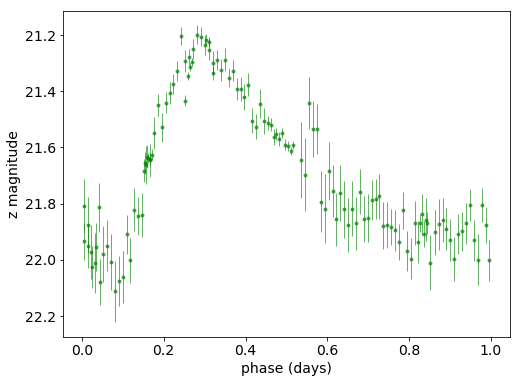

In [12]:
fig

## Compute the Lomb-Scargle model

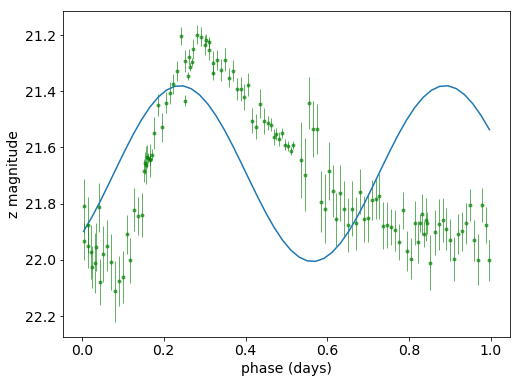

In [13]:
t_fit = np.linspace(phase.min(), phase.max())
y_fit = stats.LombScargle(t, y).model(t_fit, 1./best_period)
ax.plot(t_fit,y_fit) # keeps writing to current figure
fig  # repeats the (possibly updated) figure

**A simple sinusoid is not a good model for RR Lyrae pulsations!!** --> Idea for improvement: fit more realistic models, e.g. via RR Lyrae templates.

## Ideas

- Fit physical models of RR Lyrae pulsations

- template-based fitting

- Identify "all" variable sources in the catalogs, and classify them (ML, random forest, ...)

## Resources

Lomb, N.R. (1976) "Least-squares frequency analysis of unequally spaced data". Astrophysics and Space Science. 39 (2): 447–462: http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L

Scargle, J. D. (1982) "Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data". Astrophysical Journal. 263, 835: http://adsabs.harvard.edu/doi/10.1086/160554

Vivas et al. 2016 (2016, AJ, 151, 118) "Variable Stars in the Field of the Hydra II Ultra-Faint Dwarf Galaxy": http://adsabs.harvard.edu/abs/2016AJ....151..118V

Jake VanderPlas' blog on Lomb-Scargle periodograms and on fitting RR Lyrae lightcurves with templates: https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

Lomb-Scargle periodograms in `astropy`: http://docs.astropy.org/en/stable/stats/lombscargle.html

RR Lyrae variables on wikipedia: https://en.wikipedia.org/wiki/RR_Lyrae_variable